In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np

import seaborn as sns
import matplotlib as mpl
from lonboard import Map, viz, SolidPolygonLayer, PathLayer

In [2]:
from typing import List


def create_grid(
    gdf: None,
    bounds: List[float] | None = None,
    n_cells=10,
    overlap=False,
    crs="EPSG:4326",
):
    """Create square grid that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    see https://james-brennan.github.io/posts/fast_gridding_geopandas/
    """

    import geopandas as gpd
    import shapely

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    # get cell size
    cell_size = (xmax - xmin) / n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            # print (gdf.overlay(poly, how='intersection'))
            grid_cells.append(poly)

    cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        cells = cells.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return cells


def create_hex_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:4326"):
    """Hexagonal grid over geometry.
    See https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html
    """

    from shapely.geometry import Polygon
    import geopandas as gpd

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    unit = (xmax - xmin) / n_cells
    a = np.sin(np.pi / 3)
    cols = np.arange(np.floor(xmin), np.ceil(xmax), 3 * unit)
    rows = np.arange(np.floor(ymin) / a, np.ceil(ymax) / a, unit)

    # print (len(cols))
    hexagons = []
    for x in cols:
        for i, y in enumerate(rows):
            if i % 2 == 0:
                x0 = x
            else:
                x0 = x + 1.5 * unit

            hexagons.append(
                Polygon(
                    [
                        (x0, y * a),
                        (x0 + unit, y * a),
                        (x0 + (1.5 * unit), (y + unit) * a),
                        (x0 + unit, (y + (2 * unit)) * a),
                        (x0, (y + (2 * unit)) * a),
                        (x0 - (0.5 * unit), (y + unit) * a),
                    ]
                )
            )

    grid = gpd.GeoDataFrame({"geometry": hexagons}, crs=crs)
    grid["grid_area"] = grid.area
    grid = grid.reset_index().rename(columns={"index": "grid_id"})
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        grid = grid.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return grid

In [3]:
# Liens data.montpellier3m.fr
poles_zonage_3m_url = "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_PolesZonage_0.zip"

# cadastre archive contains multiple shapefiles (hydro, bati...)
cadastre_3m_url = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_Cadastre.zip"
)
contour_3m_url = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_Contours.zip"
)
occsol_3m_url = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_OccupSol.zip"
)

In [4]:
hydro = gpd.read_file("./data/3m/MMM_MMM_Cadastre/hydro.shp", crs="EPSG:2154")
hydro_4326 = hydro.to_crs(4326)
hydro_4326.head()

,Codcomm,Nom,Shape_Leng,Shape_Area,geometry
0,340022,Cours d'eau,487.376664,1173.38270,"POLYGON ((4.02933 43.66297, 4.02938 43.66286, ..."
1,340022,Cours d'eau,227.808713,231.65925,"POLYGON ((4.02342 43.65939, 4.02343 43.65934, ..."
2,340022,Cours d'eau,471.711913,771.88485,"POLYGON ((4.02705 43.66378, 4.02738 43.66370, ..."
3,340022,Cours d'eau,248.795001,247.59915,"POLYGON ((4.02559 43.66473, 4.02561 43.66474, ..."
4,340022,Cours d'eau,65.798798,46.63380,"POLYGON ((4.02663 43.66381, 4.02663 43.66383, ..."


In [ ]:
occsol = gpd.read_file(
    "./data/3m/MMM_MMM_OccupSol/MMM_MMM_OccupSol.shp", crs="EPSG:2154"
)
occsol["area_sqm"] = occsol["geometry"].area
occsol_4326 = occsol.to_crs(4326)
occsol_4326.head()

In [5]:
occsol = gpd.read_file(
    "./data/3m/MMM_MMM_Contours/MMM_MMM_Contours.shp", crs="EPSG:2154"
)
occsol["area_sqm"] = occsol["geometry"].area
occsol_4326 = occsol.to_crs(4326)
occsol_4326.head()

,nom,geometry,area_sqm
0,Montpellier Méditerranée Métropole,"POLYGON ((3.93860 43.58388, 3.93873 43.58380, ...",4.390615e+08


In [19]:
occsol_4326 = occsol_4326[
    [
        "c2021_niv1",
        "lib21_niv1",
        "c2021_niv2",
        "lib21_niv2",
        "c2021_niv3",
        "lib21_niv3",
        "c2021_niv4",
        "lib21_niv4",
        "geometry",
        "area_sqm",
    ]
]
occsol_4326.head()

,c2021_niv1,lib21_niv1,c2021_niv2,lib21_niv2,c2021_niv3,lib21_niv3,c2021_niv4,lib21_niv4,geometry,area_sqm
0,7,Espaces naturels non boisés,78,Marais et tourbières,782,Marais maritimes,7820,Marais maritimes,"POLYGON ((3.52091 43.33206, 3.52067 43.33208, ...",52.109847
1,5,Espaces agricoles,51,Terres arables non inondées et espaces prairia...,512,Espaces libres urbains,5121,Espaces libres urbains,"POLYGON ((4.04166 43.72099, 4.04181 43.72099, ...",42.143768
2,5,Espaces agricoles,51,Terres arables non inondées et espaces prairia...,512,Espaces libres urbains,5121,Espaces libres urbains,"POLYGON ((4.00635 43.65290, 4.00705 43.65311, ...",844.590079
3,8,Eau,82,Eaux continentales ou littorales,822,Plans d'eau et lagunes littorales,8220,Plans d'eau et lagunes littorales,"POLYGON ((3.99209 43.58774, 3.99106 43.58706, ...",2974.821151
4,5,Espaces agricoles,51,Terres arables non inondées et espaces prairia...,512,Espaces libres urbains,5121,Espaces libres urbains,"POLYGON ((3.72840 43.55274, 3.72856 43.55307, ...",1387.993852


In [20]:
layer = SolidPolygonLayer.from_geopandas(occsol_4326)
m = Map(layers=[layer])
m

Map(layers=[SolidPolygonLayer(table=pyarrow.Table
c2021_niv1: uint8
lib21_niv1: string
c2021_niv2: uint8
lib21…

In [28]:
from palettable.colorbrewer.sequential import Blues_8
from lonboard.colormap import apply_continuous_cmap

layer.get_fill_color = apply_continuous_cmap(occsol_4326["c2021_niv1"] / 7, Blues_8)

In [23]:
occsol_4326_niv1_area = occsol_4326.groupby(["c2021_niv1", "lib21_niv1"])[
    "area_sqm"
].sum()
occsol_4326_niv1_area.head()

c2021_niv1  lib21_niv1                                                                
1           Espaces urbanisés                                                             1.929791e+08
2           Surfaces industrielles ou commerciales et infrastructures de communication    7.168349e+07
3           Extraction de matériaux, décharges, chantiers                                 1.014704e+07
4           Espaces récréatifs                                                            2.494645e+07
5           Espaces agricoles                                                             4.771698e+08
Name: area_sqm, dtype: float64

/var/folders/99/kj4r22n55cv1_0hkwlk2tcph0000gn/T/ipykernel_42314/4172846853.py:85: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["grid_area"] = grid.area


(3.626136143226106, 4.106310266135886, 43.43238219845678, 43.79624481355155)

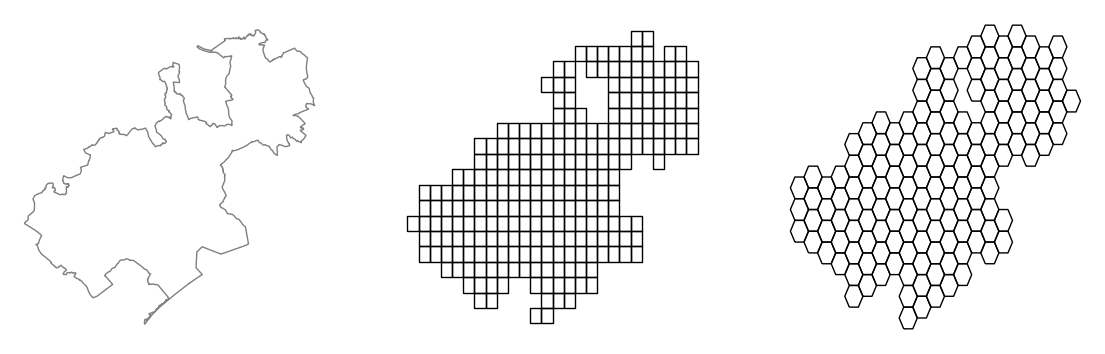

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 7))
axs = ax.flat
occsol_4326.plot(ec="gray", fc="none", figsize=(10, 10), ax=axs[0])
grid = create_grid(occsol_4326, n_cells=25, overlap=True, crs="EPSG:4326")
grid.plot(fc="none", ec="black", ax=axs[1])
hexgrid = create_hex_grid(occsol_4326, n_cells=30, overlap=True, crs="EPSG:4326")
hexgrid.plot(fc="none", ec="black", ax=axs[2])
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")

(751359.7709607523, 787778.8790913981, 6261715.771996897, 6298790.788065171)

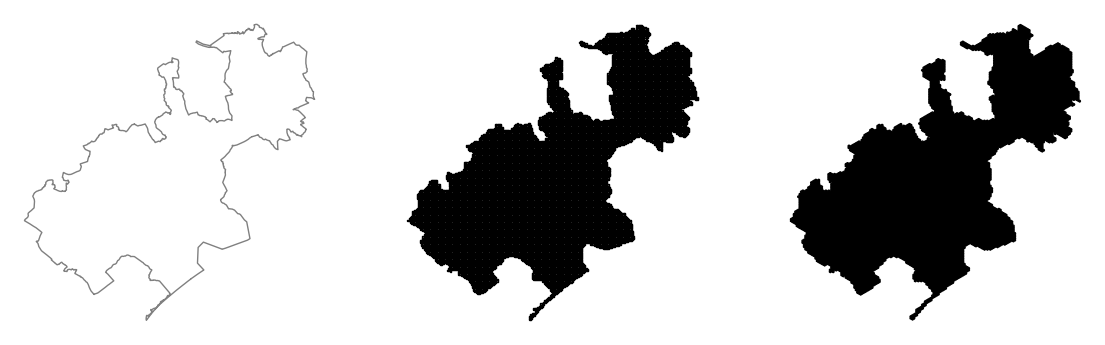

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))
axs = ax.flat
occsol.plot(ec="gray", fc="none", figsize=(10, 10), ax=axs[0])
grid = create_grid(occsol, n_cells=250, overlap=True, crs="EPSG:2154")
grid.plot(fc="none", ec="black", ax=axs[1])
hexgrid = create_hex_grid(occsol, n_cells=300, overlap=True, crs="EPSG:2154")
hexgrid.plot(fc="none", ec="black", ax=axs[2])
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")

In [25]:
grid["size"] = grid["geometry"].length / 4
grid.head()

,geometry,index_right,nom,area_sqm,size
85,"POLYGON ((752938.924 6274583.727, 752938.924 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
341,"POLYGON ((753070.480 6274583.727, 753070.480 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
342,"POLYGON ((753070.480 6274715.283, 753070.480 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
343,"POLYGON ((753070.480 6274846.839, 753070.480 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
596,"POLYGON ((753202.036 6274452.171, 753202.036 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608


In [18]:
layer = SolidPolygonLayer.from_geopandas(occsol_4326)
grid = SolidPolygonLayer.from_geopandas(grid)
m = Map(layers=[layer, grid])
m

/Users/gaetan/.pyenv/versions/3.10.12/envs/3m-ai-dataprep-env/lib/python3.10/site-packages/lonboard/_layer.py:133: UserWarning: GeoDataFrame being reprojected to EPSG:4326
  warnings.warn("GeoDataFrame being reprojected to EPSG:4326")


Map(layers=[SolidPolygonLayer(table=pyarrow.Table
nom: string
area_sqm: double
geometry: list<item: list<item:…

In [19]:
from palettable.colorbrewer.sequential import Blues_8
from lonboard.colormap import apply_continuous_cmap

layer.get_fill_color = apply_continuous_cmap(occsol_4326["c2021_niv1"] / 7, Blues_8)
grid.get_fill_color = [13, 124, 56, 12]
grid.extruded = True
grid.wireframe = True
grid.get_elevation = 25
grid.get_line_color = [0, 0, 0, 255]

KeyError: 'c2021_niv1'

<Axes: >

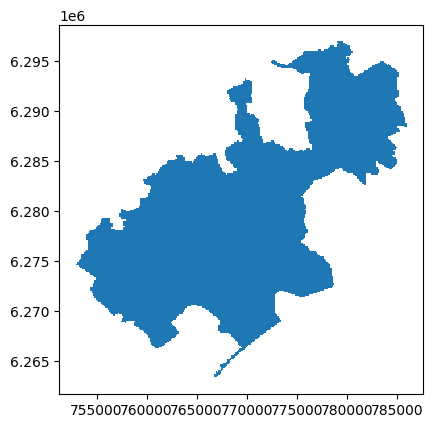

In [31]:
grid.plot()

In [37]:
grid.head()

,geometry,index_right,nom,area_sqm,size
85,"POLYGON ((752938.924 6274583.727, 752938.924 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
341,"POLYGON ((753070.480 6274583.727, 753070.480 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
342,"POLYGON ((753070.480 6274715.283, 753070.480 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
343,"POLYGON ((753070.480 6274846.839, 753070.480 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608
596,"POLYGON ((753202.036 6274452.171, 753202.036 6...",0,Montpellier Méditerranée Métropole,4.390615e+08,131.55608


<Axes: >

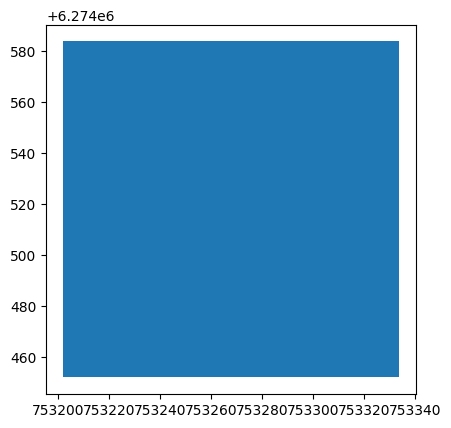

In [42]:
grid_item = grid.loc[[596], "geometry"]
grid_item.plot()

In [50]:
import time
from urllib.parse import urlparse, parse_qs
import requests
import xarray as xr


def formatBBox(bounds):
    xmin, ymin, xmax, ymax = bounds
    return f"{xmin},{ymin},{xmax},{ymax}"


def getTileUrl(
    layerName="ORTHOIMAGERY.ORTHOPHOTOS.IRC",
    bbox="785802.3085941937752,6336806.404346071184,786208.1537742479704,6337311.468582574278",
    size=256,
):
    base_url = "https://wxs.ign.fr/ortho/geoportail/r/wms"
    params = f"SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX={bbox}&CRS=EPSG:2154&WIDTH={size}&HEIGHT={size}&LAYERS={layerName}&STYLES=&FORMAT=image/geotiff&DPI=72&MAP_RESOLUTION=72&FORMAT_OPTIONS=dpi:72"
    return f"{base_url}?{params}"


def download_image_from_url(url=""):
    t0 = time.time()
    parsed_url = urlparse(url)
    layer_param = parse_qs(parsed_url.query)["LAYERS"][0]
    bbox_param = parse_qs(parsed_url.query)["BBOX"][0]
    bbox_tuple = tuple(map(float, bbox_param.split(",")))
    if layer_param == "ORTHOIMAGERY.ORTHOPHOTOS.IRC":
        out_dir = "./tiles/irc"
    elif layer_param == "ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO":
        out_dir = "./downloads/tiles/ortho"
    else:
        out_dir = "./downloads/tiles/unknown"
    try:
        r = requests.get(url)
        print(r.status_code)
        if r.status_code == 200:
            image_path = f"{out_dir}/image_{hash(bbox_tuple)}.tiff"
            with open(image_path, "wb") as f:
                f.write(r.content)
        return (image_path, time.time() - t0, url)
    except Exception as e:
        print("Exception in download_url():", e)

In [51]:
url = getTileUrl(
    layerName="ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO",
    bbox=formatBBox(grid_item.total_bounds),
)
url

'https://wxs.ign.fr/ortho/geoportail/r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=753202.0360484155,6274452.17075707,753333.5921283576,6274583.726837012&CRS=EPSG:2154&WIDTH=256&HEIGHT=256&LAYERS=ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO&STYLES=&FORMAT=image/geotiff&DPI=72&MAP_RESOLUTION=72&FORMAT_OPTIONS=dpi:72'

In [52]:
d = download_image_from_url(url)

200


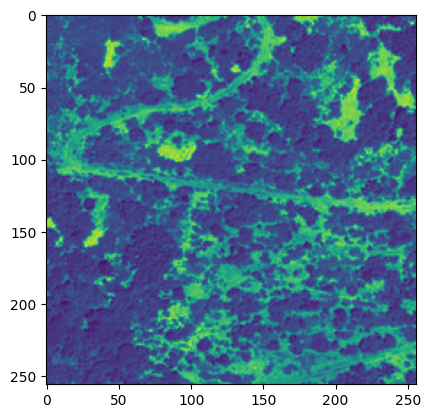

<Axes: >

In [53]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

fp = r"GeoTiff_Image.tif"
img = rasterio.open(d[0])
show(img.read(3))
# plt.imshow(img.read(3))

In [101]:
occsol.head()

,c1994_niv1,lib94_niv1,c1994_niv2,lib94_niv2,c2004_niv1,lib04_niv1,c2004_niv2,lib04_niv2,c2004_niv3,lib04_niv3,...,milieu2004,milieu2008,milieu2010,milieu2012,milieu2015,milieu2017,milieu2019,milieu2021,geometry,area_sqm
0,7,Espaces naturels non boisés,78,Marais et tourbières,7,Espaces naturels non boisés,78,Marais et tourbières,782,Marais maritimes,...,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,"POLYGON ((742269.535 6248240.552, 742250.300 6...",52.109847
1,5,Espaces agricoles,52,Cultures permanentes,5,Espaces agricoles,52,Cultures permanentes,521,Vignes,...,AGRICOLE,AGRICOLE,AGRICOLE,AGRICOLE,AGRICOLE,AGRICOLE,ARTIFICIALISE,NATUREL,"POLYGON ((783953.823 6291883.226, 783966.394 6...",42.143768
2,2,Surfaces industrielles ou commerciales et infr...,22,Infrastructures routières et ferroviaires,2,Surfaces industrielles ou commerciales et infr...,22,Infrastructures routières et ferroviaires,222,Réseau ferroviaire et espaces associés,...,ARTIFICIALISE,ARTIFICIALISE,ARTIFICIALISE,ARTIFICIALISE,ARTIFICIALISE,ARTIFICIALISE,NATUREL,NATUREL,"POLYGON ((781205.235 6284279.038, 781260.980 6...",844.590079
3,8,Eau,82,Eaux continentales ou littorales,8,Eau,82,Eaux continentales ou littorales,822,Plans d'eau et lagunes littorales,...,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,NATUREL,"POLYGON ((780145.613 6277024.020, 780063.022 6...",2974.821151
4,5,Espaces agricoles,52,Cultures permanentes,5,Espaces agricoles,52,Cultures permanentes,521,Vignes,...,AGRICOLE,AGRICOLE,ARTIFICIALISE,NATUREL,NATUREL,ARTIFICIALISE,NATUREL,NATUREL,"POLYGON ((758879.856 6272901.789, 758892.140 6...",1387.993852


In [115]:
from shapely.geometry import box

# polygon = box(grid_item.total_bounds[0], grid_item.total_bounds[1], grid_item.total_bounds[2], grid_item.total_bounds[3])

# extent = gpd.GeoDataFrame([1], geometry=[polygon], crs=4326)
clipped = gpd.clip(occsol, grid_item.total_bounds)
clipped.head()

,c1994_niv1,lib94_niv1,c1994_niv2,lib94_niv2,c2004_niv1,lib04_niv1,c2004_niv2,lib04_niv2,c2004_niv3,lib04_niv3,...,milieu2004,milieu2008,milieu2010,milieu2012,milieu2015,milieu2017,milieu2019,milieu2021,geometry,area_sqm


In [119]:
grid_item.total_bounds

array([ 739754.26719998, 6250348.78720265,  739979.89999998,
       6250574.42000265])

In [120]:
hydro = gpd.read_file("./data/3m/MMM_MMM_Cadastre/hydro.shp", crs="EPSG:2154")
clipped = gpd.clip(hydro, grid_item.total_bounds)
clipped.head()

,Codcomm,Nom,Shape_Leng,Shape_Area,geometry


<Axes: >

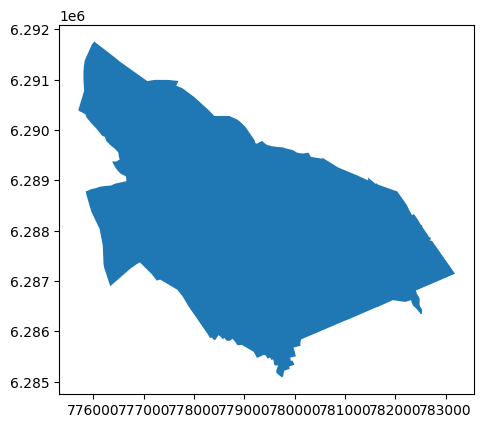

In [126]:
boundaries = gpd.read_file(
    "./data/3m/MMM_MMM_PolesZonage/MMM_MMM_PolesZonage.shp", crs="EPSG:2154"
)
castries = boundaries[boundaries["nom"] == "CASTRIES"]
castries.plot()
castries_hydro

<Axes: >

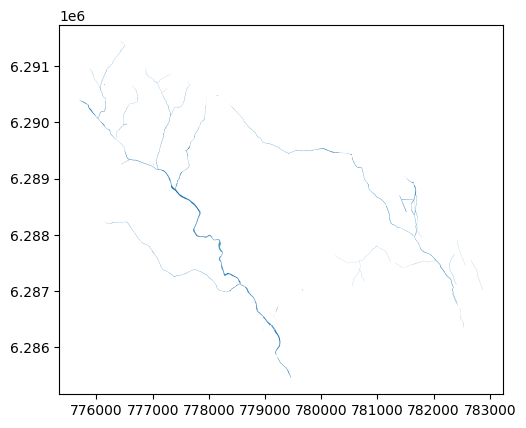

In [129]:
castries_hydro = hydro.clip(castries)
castries_hydro.plot()

In [137]:
grid.head()
grid_light = grid[["geometry", "area_sqm", "size"]]
grid_light.reset_index()
grid_light.insert(1, "id", range(1, 1 + len(grid_light)))
grid_light.head()

,geometry,id,area_sqm,size
24,"POLYGON ((739754.267 6250348.787, 739754.267 6...",1,89599.458945,225.6328
279,"POLYGON ((739979.900 6250348.787, 739979.900 6...",2,89599.458945,225.6328
280,"POLYGON ((739979.900 6250574.420, 739979.900 6...",3,89599.458945,225.6328
534,"POLYGON ((740205.533 6250348.787, 740205.533 6...",4,89599.458945,225.6328
535,"POLYGON ((740205.533 6250574.420, 740205.533 6...",5,89599.458945,225.6328


<Axes: >

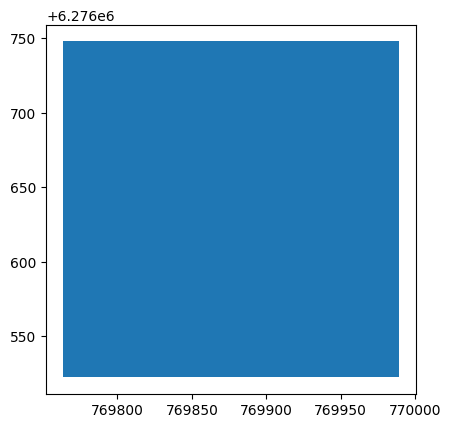

In [169]:
gitem = grid_light[grid_light["id"] == 17267]
gitem.plot()

In [170]:
gitem_hydro = hydro.clip(gitem)
gitem_hydro.head()

,Codcomm,Nom,Shape_Leng,Shape_Area,geometry


<Axes: >

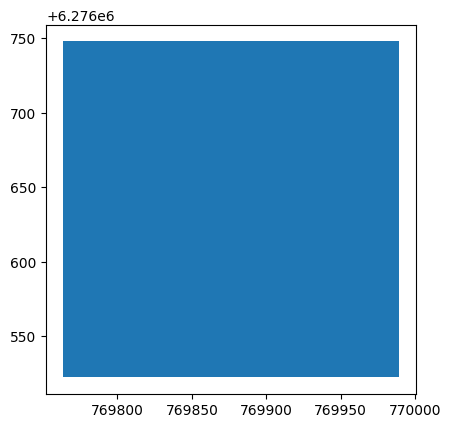

In [172]:
gitem_boundaries = boundaries.clip(gitem)
gitem_boundaries.plot()

In [183]:
occsol_4326.head()

,c2021_niv1,lib21_niv1,c2021_niv2,lib21_niv2,c2021_niv3,lib21_niv3,c2021_niv4,lib21_niv4,geometry,area_sqm
0,7,Espaces naturels non boisés,78,Marais et tourbières,782,Marais maritimes,7820,Marais maritimes,"POLYGON ((3.52091 43.33206, 3.52067 43.33208, ...",52.109847
1,5,Espaces agricoles,51,Terres arables non inondées et espaces prairia...,512,Espaces libres urbains,5121,Espaces libres urbains,"POLYGON ((4.04166 43.72099, 4.04181 43.72099, ...",42.143768
2,5,Espaces agricoles,51,Terres arables non inondées et espaces prairia...,512,Espaces libres urbains,5121,Espaces libres urbains,"POLYGON ((4.00635 43.65290, 4.00705 43.65311, ...",844.590079
3,8,Eau,82,Eaux continentales ou littorales,822,Plans d'eau et lagunes littorales,8220,Plans d'eau et lagunes littorales,"POLYGON ((3.99209 43.58774, 3.99106 43.58706, ...",2974.821151
4,5,Espaces agricoles,51,Terres arables non inondées et espaces prairia...,512,Espaces libres urbains,5121,Espaces libres urbains,"POLYGON ((3.72840 43.55274, 3.72856 43.55307, ...",1387.993852


In [184]:
from lonboard import basemap

grid_light_4326 = grid_light.to_crs(4326)
hydro_4326 = hydro.to_crs(4326)
boundaries_4326 = boundaries.to_crs(4326)
grid_light_4326_layer = SolidPolygonLayer.from_geopandas(grid_light_4326)
hydro_4326_layer = SolidPolygonLayer.from_geopandas(hydro_4326)
boundaries_4326_layer = SolidPolygonLayer.from_geopandas(boundaries_4326)

In [185]:
landcover_4326_layer = SolidPolygonLayer.from_geopandas(occsol_4326)

In [187]:
grid_light_4326_layer.get_fill_color = [13, 124, 56]
grid_light_4326_layer.get_fill_color = [13, 124, 56]
grid_light_4326_layer.extruded = True
grid_light_4326_layer.wireframe = True
grid_light_4326_layer.opacity = 0.5
grid_light_4326_layer.get_elevation = 25
# grid_light_4326_layer.get_line_color = [0, 0, 0, 255]
boundaries_4326_layer.get_fill_color = [125, 12, 200]
boundaries_4326_layer.opacity = 0.3
landcover_4326_layer.get_fill_color = apply_continuous_cmap(
    landcover_4326_layer["c2021_niv1"] / 7, Blues_8
)

TypeError: 'SolidPolygonLayer' object is not subscriptable

In [ ]:
m2 = Map(
    layers=[
        hydro_4326_layer,
        boundaries_4326_layer,
        grid_light_4326_layer,
        landcover_4326_layer,
    ],
    basemap_style=basemap.CartoBasemap.DarkMatterNoLabels,
)
m2

In [186]:
m3 = Map(layers=[landcover_4326_layer, boundaries_4326_layer])
m3

Map(layers=[SolidPolygonLayer(table=pyarrow.Table
c2021_niv1: uint8
lib21_niv1: string
c2021_niv2: uint8
lib21…

In [188]:
clipped_lancover = occsol_4326.clip(boundaries_4326)
clipped_lancover

,c2021_niv1,lib21_niv1,c2021_niv2,lib21_niv2,c2021_niv3,lib21_niv3,c2021_niv4,lib21_niv4,geometry,area_sqm
33464,7,Espaces naturels non boisés,72,Végétations sclérophylles,721,Maquis et garrigues,7210,Maquis et garrigues,"MULTIPOLYGON (((3.74897 43.49729, 3.74919 43.4...",3.865199e+06
55988,2,Surfaces industrielles ou commerciales et infr...,22,Infrastructures routières et ferroviaires,221,Réseau routier principal et espaces associés,2211,Réseau routier principal et espaces associés,"POLYGON ((3.77903 43.50602, 3.77901 43.50603, ...",1.099487e+05
15595,7,Espaces naturels non boisés,72,Végétations sclérophylles,721,Maquis et garrigues,7210,Maquis et garrigues,"MULTIPOLYGON (((3.77322 43.50297, 3.77322 43.5...",1.454626e+06
20628,7,Espaces naturels non boisés,72,Végétations sclérophylles,721,Maquis et garrigues,7210,Maquis et garrigues,"POLYGON ((3.76372 43.49765, 3.76372 43.49768, ...",2.987545e+03
55365,6,Espaces boisés,62,Conifères dominants,620,Conifères dominants,6200,Conifères dominants,"POLYGON ((3.76703 43.49954, 3.76698 43.49948, ...",1.714738e+04


In [189]:
clipped_lancover_layer = SolidPolygonLayer.from_geopandas(clipped_lancover)
_m4 = Map(layers=[clipped_lancover_layer, boundaries_4326_layer])
_m4

Map(layers=[SolidPolygonLayer(table=pyarrow.Table
c2021_niv1: uint8
lib21_niv1: string
c2021_niv2: uint8
lib21…

In [191]:
clipped_lancover_layer.get_fill_color = apply_continuous_cmap(
    clipped_lancover["c2021_niv1"] / 7, Blues_8
)

In [200]:
bounds = clipped_lancover.total_bounds

In [205]:
grid_light.to_crs(4326)[]
clipped_landovers = grid_light.to_crs(4326).clip()

17998

In [208]:
grid_light_4326 = grid_light.to_crs(4326)
castries_4326 = boundaries_4326[boundaries_4326["nom"] == "CASTRIES"]
grids_in_castries = gpd.sjoin(grid_light_4326, castries_4326, op="within", how="inner")
grids_in_castries.head()

/Users/gaetan/.pyenv/versions/3.10.12/envs/3m-ai-dataprep-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,geometry,id,area_sqm,size,index_right,codcomm,nom,POLE
41247,"POLYGON ((3.94345 43.68924, 3.94348 43.69127, ...",21081,67518.055701,225.6328,3,340058,CASTRIES,Cadoule et Bérange
41001,"POLYGON ((3.94095 43.70753, 3.94098 43.70957, ...",21085,91783.353471,225.6328,3,340058,CASTRIES,Cadoule et Bérange
41002,"POLYGON ((3.94098 43.70957, 3.94102 43.71160, ...",21086,91783.353471,225.6328,3,340058,CASTRIES,Cadoule et Bérange
41255,"POLYGON ((3.94372 43.70548, 3.94375 43.70751, ...",21087,91783.353471,225.6328,3,340058,CASTRIES,Cadoule et Bérange
41256,"POLYGON ((3.94375 43.70751, 3.94378 43.70954, ...",21088,91783.353471,225.6328,3,340058,CASTRIES,Cadoule et Bérange


In [216]:
gitem = grids_in_castries[grids_in_castries["id"] == 21086]
lancover_castries_21086 = occsol_4326.clip(gitem)
len(lancover_castries_21086)

6

In [214]:
lancover_castries_21086.head()

,c2021_niv1,lib21_niv1,c2021_niv2,lib21_niv2,c2021_niv3,lib21_niv3,c2021_niv4,lib21_niv4,geometry,area_sqm
7974,7,Espaces naturels non boisés,72,Végétations sclérophylles,721,Maquis et garrigues,7210,Maquis et garrigues,"POLYGON ((3.94195 43.71154, 3.94231 43.71119, ...",90747.778578
44698,6,Espaces boisés,61,Feuillus dominants,613,Feuillus sclérophylles dominants,6130,Feuillus sclérophylles dominants,"POLYGON ((3.94288 43.70956, 3.94310 43.70976, ...",91783.353471
59554,3,"Extraction de matériaux, décharges, chantiers",31,"Extraction de matériaux, décharges, chantiers",311,Extraction de matériaux,3111,Extraction de matériaux,"POLYGON ((3.94330 43.71136, 3.94330 43.71143, ...",3197.025068
55956,2,Surfaces industrielles ou commerciales et infr...,22,Infrastructures routières et ferroviaires,221,Réseau routier principal et espaces associés,2211,Réseau routier principal et espaces associés,"POLYGON ((3.94257 43.71006, 3.94312 43.71086, ...",25461.456275
2824,7,Espaces naturels non boisés,72,Végétations sclérophylles,721,Maquis et garrigues,7210,Maquis et garrigues,"POLYGON ((3.94381 43.71118, 3.94375 43.71107, ...",44622.703321


<Axes: >

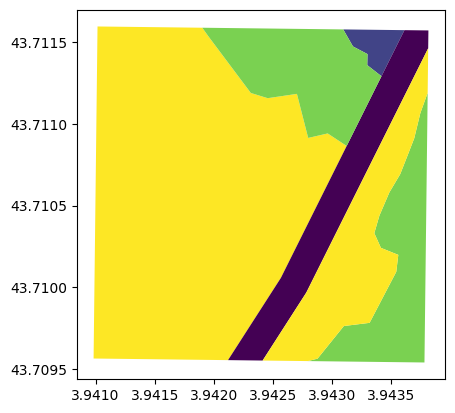

In [217]:
lancover_castries_21086.plot(column="c2021_niv1")

In [244]:
lancover_castries_21086["c2021_niv1"] = pd.to_numeric(
    lancover_castries_21086["c2021_niv1"], downcast="float"
)
lancover_castries_21086.dtypes

c2021_niv1     float32
lib21_niv1      object
c2021_niv2       int64
lib21_niv2      object
c2021_niv3       int64
lib21_niv3      object
c2021_niv4       int64
lib21_niv4      object
geometry      geometry
area_sqm       float64
dtype: object

In [269]:
from geocube.api.core import make_geocube

out_grid = make_geocube(
    vector_data=lancover_castries_21086,
    output_crs="epsg:4326",
    resolution=(-0.000005, 0.000005),
    measurements=["c2021_niv1"],
    fill=-9999,
)

In [270]:
out_grid

<xarray.Dataset>
Dimensions:      (y: 412, x: 568)
Coordinates:
  * y            (y) float64 43.71 43.71 43.71 43.71 ... 43.71 43.71 43.71 43.71
  * x            (x) float64 3.941 3.941 3.941 3.941 ... 3.944 3.944 3.944 3.944
    spatial_ref  int64 0
Data variables:
    c2021_niv1   (y, x) float32 -9.999e+03 -9.999e+03 ... -9.999e+03 -9.999e+03

In [271]:
out_grid.c2021_niv1.rio.to_raster("./masks/lancover_castries_21086.tif")

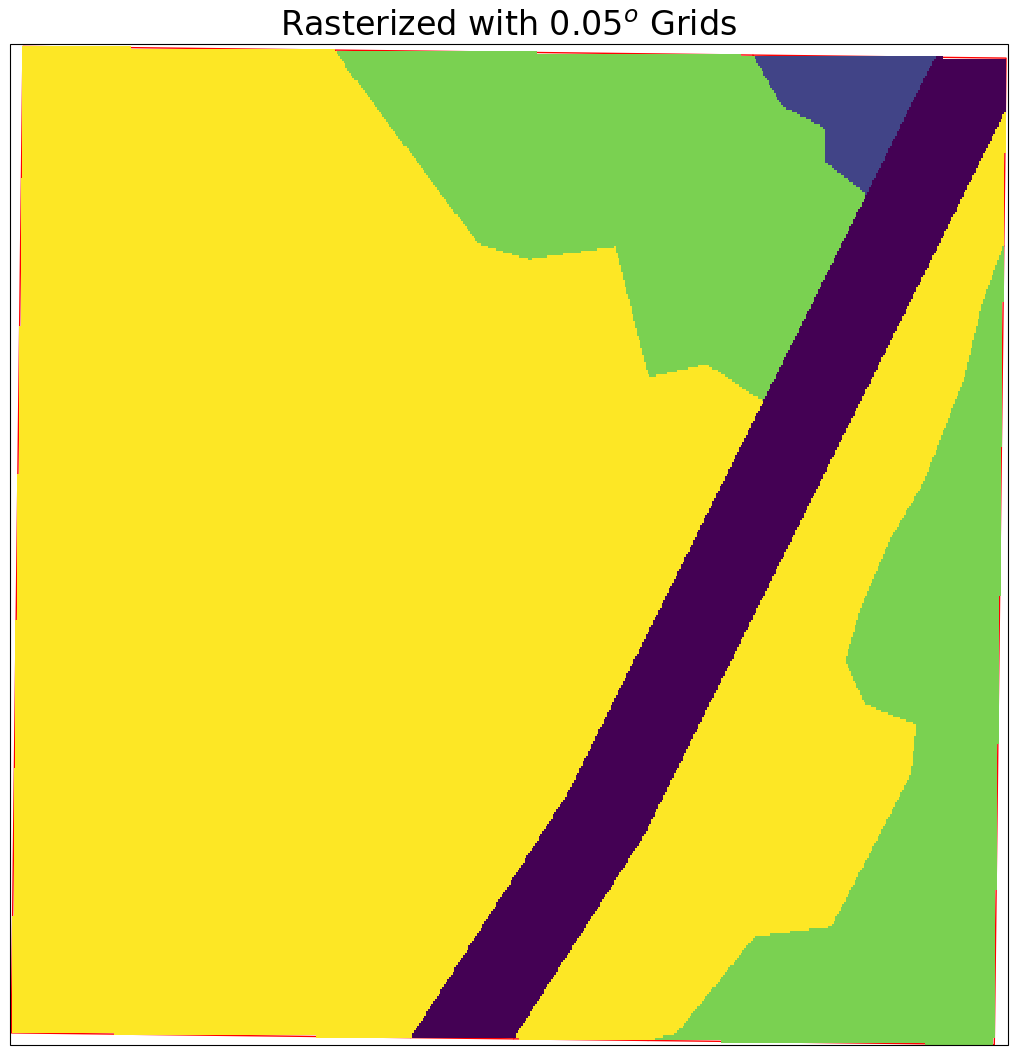

In [272]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
lancover_castries_21086.plot(ax=ax, facecolor="None", edgecolor="r")
da_grib = xr.where(out_grid.c2021_niv1 < -1999.0, np.nan, out_grid.c2021_niv1)
da_grib.plot(ax=ax, add_colorbar=False)

ax.set_title("Rasterized with 0.05$^o$ Grids", fontsize=24)